# Experiment 2: Averages hide critical failures

This notebook reproduces **Experiment 2** from our paper on validation pitfalls in surgical AI.
It demonstrates how **globally aggregated performance metrics can conceal clinically critical failure modes** that only become visible under stratified analysis.

The experiment uses multi-instance instrument segmentation results from the **RobustMIS challenge** and investigates how algorithm performance changes under specific, safety-relevant visual conditions such as smoke, motion, or intersecting instruments.

## Core idea

Performance in surgical AI is commonly reported as a single global score, aggregating results across all frames or cases.
While convenient, this practice implicitly assumes that errors are evenly distributed across conditions. However, surgical video data is highly heterogeneous. Visual artifacts and challenging intraoperative conditions. e.g., smoke, rapid motion, overexposure, or instrument overlap, can substantially degrade algorithm performance.
If these conditions are rare, their impact may be **masked by global aggregation**, despite being critical for patient safety. 
This experiment contrasts non-stratified aggregation (i.e., median performance computed over all frames) with stratified aggregation (i.e., median performance computed on subsets of frames exhibiting specific image artifacts).

## Task and dataset

- **Task**: Multi-instance instrument segmentation  
- **Dataset**: Performance results of the RobustMIS 2019 challenge
- **Algorithms**: Pseudonymized challenge submissions (A1-A7)
- **Metric**: Median multi-Instance Dice Similarity Coefficient (MI_DSC)

Algorithm predictions are fixed. 

## Artifact-based stratification

Stratification is performed using structured frame-level metadata describing visual artifacts and image properties.
Each frame may contain multiple artifacts; subsets are therefore **not mutually exclusive**. The following conditions are considered:

- Blood
- Motion
- Reflections
- Smoke
- Instrument(s) covered by material
- Overexposed instruments
- Underexposed instruments
- Intersecting instruments
- Low-artifact scenes (≤ 1 annotated artifact)

## Aggregation strategy

For each algorithm:

1. The **median MI_DSC over all frames** is computed as the non-stratified baseline.
2. The **median MI_DSC within each artifact-specific subset** is computed.
3. The **difference between stratified and baseline medians** is calculated per algorithm.

The median (rather than the mean) is used throughout to reduce sensitivity to outliers.

## Uncertainty estimation

To estimate uncertainty of performance differences, we apply hierarchical bootstrapping with 1,000 iterations to calculate confidence intervals.

- Hierarchy level: patient / video
- Videos are resampled with replacement.
- Frames are resampled within each selected video.
- For each bootstrap iteration, the difference in median MI_DSC between stratified and non-stratified conditions is computed.

## Software dependencies

This notebook uses standard Python libraries for data handling, statistical resampling, metric computation, and visualization. All required imports are listed explicitly below.

## How to run

Run the notebook top-to-bottom (Kernel --> Restart & Run All).

If paths need adjustment, do so in the dedicated "data loading" section only.

In [1]:
# =========================
# core libraries
# =========================
import numpy as np
import pandas as pd

# =========================
# plotting
# =========================
import matplotlib.pyplot as plt

# =========================
# reproducibility settings
# =========================
RANDOM_SEED = 2
rng = np.random.default_rng(RANDOM_SEED)
N_BOOTSTRAPS = 1000

### Data loading and preprocessing

This section loads the pseudonymized RobustMIS multi-instance segmentation results and the corresponding frame-level metadata describing visual artifacts. Only tabular result files are required. No raw images or videos are accessed. 

#### RobustMIS multi-instance segmentation results

The RobustMIS results are provided as a tabular file containing frame-level performance values for all participating challenge submissions in the multi-instance instrument segmentation task. Relevant columns for this experiment include:

- `frame`: Unique frame identifier 
- `surgery_number`: Patient / video identifier 
- `team_name`:  Algorithm identifier, pseudonymized as A1-A7
- `MI_DSC`:  Frame-level multi-instance Dice Similarity Coefficient (MI_DSC)

For this experiment, the analysis is restricted to Stage 3 of the original RobustMIS challenge.

---

#### Frame-level metadata (visual artifacts)

To enable stratified analysis, the challenge results are combined with structured frame-level metadata describing visual artifacts and image properties. Relevant metadata columns include binary indicator variables (`0/1`) encoding the presence
of specific artifacts:

- `toggle_background_blood`, `toggle_instrument_blood`
- `toggle_background_motion`, `toggle_instrument_motion`
- `toggle_background_smoke`, `toggle_instrument_smoke`
- `toggle_background_reflections`, `toggle_instrument_covered_reflections`
- `toggle_instrument_covered_material`
- `toggle_instrument_covered_instrument`
- `toggle_instrument_overexposed`
- `toggle_instrument_underexposed`

Multiple artifacts may co-occur within the same frame. As a result, artifact-based subsets used for stratified analysis may not be mutually exclusive.

In [2]:
# Load RobustMIS frame-level results
robustmis_data= pd.read_csv('robustmis_results_multiple_instance_segmentation_anonym.csv')

print(robustmis_data[['surgery_number', 'frame']].nunique())

robustmis_data

surgery_number      10
frame             2231
dtype: int64


,frame_nr,MI_DSC,MI_NSD,stage,surgery_number,surgery_type,task,team_name,frame
0,39000,0.551451,0.587949,Stage_3,8,Sigma,Testcase.MULTIPLE_INSTANCE_SEGMENTATION,A3,39000_Sigma_8
1,39000,0.717838,0.784269,Stage_3,8,Sigma,Testcase.MULTIPLE_INSTANCE_SEGMENTATION,A5,39000_Sigma_8
2,39000,0.308659,0.349094,Stage_3,8,Sigma,Testcase.MULTIPLE_INSTANCE_SEGMENTATION,A5,39000_Sigma_8
3,39000,0.339716,0.404375,Stage_3,8,Sigma,Testcase.MULTIPLE_INSTANCE_SEGMENTATION,A7,39000_Sigma_8
4,39000,0.456121,0.516183,Stage_3,8,Sigma,Testcase.MULTIPLE_INSTANCE_SEGMENTATION,A6,39000_Sigma_8
...,...,...,...,...,...,...,...,...,...
17843,66103,0.425646,0.497158,Stage_3,2,Sigma,Testcase.MULTIPLE_INSTANCE_SEGMENTATION,A7,66103_Sigma_2
17844,66103,0.558866,0.598949,Stage_3,2,Sigma,Testcase.MULTIPLE_INSTANCE_SEGMENTATION,A6,66103_Sigma_2
17845,66103,0.570267,0.598528,Stage_3,2,Sigma,Testcase.MULTIPLE_INSTANCE_SEGMENTATION,A2,66103_Sigma_2
17846,66103,0.415346,0.441149,Stage_3,2,Sigma,Testcase.MULTIPLE_INSTANCE_SEGMENTATION,A4,66103_Sigma_2


In [3]:
# Load metadata 
metadata = pd.read_csv('meta_data_aggregated.csv')
metadata = metadata[metadata["stage"] == "Stage_3"].copy()

metadata

,Unnamed: 0,frame,stage,toggle_background_blood,toggle_background_motion,toggle_background_other_objects,toggle_background_reflections,toggle_background_smoke,toggle_instrument_blood,toggle_instrument_covered_instrument,toggle_instrument_covered_material,toggle_instrument_covered_reflections,toggle_instrument_covered_tissue,toggle_instrument_motion,toggle_instrument_overexposed,toggle_instrument_smoke,toggle_instrument_underexposed
2,3,100500_Sigma_10,Stage_3,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,4,100500_Sigma_6,Stage_3,1,0,0,1,0,0,0,0,1,1,0,0,1,0
4,5,100500_Sigma_9,Stage_3,0,0,0,1,0,0,0,0,1,1,0,0,0,1
5,6,100587_Sigma_4,Stage_3,1,0,0,1,0,1,0,0,1,0,0,1,0,0
7,8,101152_Sigma_3,Stage_3,1,0,0,1,1,1,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3202,3203,99000_Sigma_7,Stage_3,1,0,1,1,0,0,0,0,1,1,0,0,0,1
3204,3205,99087_Sigma_4,Stage_3,1,0,0,1,1,0,0,0,1,1,0,0,1,0
3206,3207,99652_Sigma_3,Stage_3,1,0,0,1,0,0,0,0,1,1,0,0,1,0
3207,3208,104845_Sigma_9,Stage_3,0,1,1,1,0,0,0,0,0,0,0,0,0,0


In [4]:
# Merge results with metadata into one dataframe
robustmis_data = robustmis_data.merge(metadata, on="frame", how="inner")

print("Number of frames:", robustmis_data["frame"].nunique())
print("Number of videos:", robustmis_data["surgery_number"].nunique())
print("Algorithms:", sorted(robustmis_data["team_name"].unique()))

Number of frames: 2231
Number of videos: 10
Algorithms: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7']


### Artifact-specific subsets

This section defines artifact-specific subsets based on the binary metadata indicators. We additionally define a low-artifact subset containing frames with one or fewer annotated artifacts across the selected artifact indicators.

In [5]:
# Define artifact filters
ARTIFACT_DEFINITIONS = {
    "Blood": lambda df: (df["toggle_background_blood"] == 1) | (df["toggle_instrument_blood"] == 1),
    "Motion": lambda df: (df["toggle_background_motion"] == 1) | (df["toggle_instrument_motion"] == 1),
    "Reflections": lambda df: (df["toggle_background_reflections"] == 1) | (df["toggle_instrument_covered_reflections"] == 1),
    "Smoke": lambda df: (df["toggle_background_smoke"] == 1) | (df["toggle_instrument_smoke"] == 1),
    "Material": lambda df: (df["toggle_instrument_covered_material"] == 1),
    "Overexposed": lambda df: (df["toggle_instrument_overexposed"] == 1),
    "Underexposed": lambda df: (df["toggle_instrument_underexposed"] == 1),
    "Instrument Covered": lambda df: (df["toggle_instrument_covered_instrument"] == 1),
}

# Columns used to define low-artifact scenes 
LOW_ARTIFACT_COLUMNS = [
    "toggle_background_blood", "toggle_instrument_blood",
    "toggle_background_motion", "toggle_instrument_motion",
    "toggle_instrument_covered_material",
    "toggle_background_reflections", "toggle_instrument_covered_reflections",
    "toggle_background_smoke", "toggle_instrument_smoke",
    "toggle_instrument_covered_instrument",
    "toggle_instrument_overexposed",
    "toggle_instrument_underexposed",
]

In [6]:
# -------------------------
# Build artifact-specific subsets
# -------------------------
artifact_datasets = {}
for artifact_name, condition_fn in ARTIFACT_DEFINITIONS.items():
    artifact_datasets[artifact_name] = robustmis_data[condition_fn(robustmis_data)].copy()

# Low-artifact subset
artifact_count = robustmis_data[LOW_ARTIFACT_COLUMNS].sum(axis=1)
artifact_datasets["Low Artifacts"] = robustmis_data[artifact_count <= 1].copy()

# Summarize subset sizes 
n_frames_full = robustmis_data["frame"].nunique()

n_artifact = []
n_artifact.append({"Artifact": "Full", "n_frames": n_frames_full})

for artifact_name, df_subset in artifact_datasets.items():
    n_artifact.append({"Artifact": artifact_name, "n_frames": df_subset["frame"].nunique()})

n_artifact = pd.DataFrame(n_artifact)
n_artifact["Percentage"] = (n_artifact["n_frames"] / n_frames_full * 100).round(2)

n_artifact

,Artifact,n_frames,Percentage
0,Full,2231,100.00
1,Blood,1765,79.11
2,Motion,497,22.28
3,Reflections,2190,98.16
4,Smoke,702,31.47
5,Material,158,7.08
6,Overexposed,126,5.65
7,Underexposed,429,19.23
8,Instrument Covered,260,11.65
9,Low Artifacts,119,5.33


### Aggregation and differences to the non-stratified baseline

For each algorithm, we compute:

- the **non-stratified baseline**: median MI_DSC over all frames,
- the **stratified performance**: median MI_DSC within each artifact-specific subset,
- the **delta to baseline**: stratified median minus baseline median.

In [7]:
metric_col = "MI_DSC" 

# Non-stratified median MI_DSC per algorithm
baseline = (robustmis_data.groupby("team_name", as_index=False)[metric_col].median()
            .rename(columns={metric_col: "median_full"}))

# Stratified median MI_DSC per algorithm and artifact subset
stratified_rows = []
for artifact_name, df_subset in artifact_datasets.items():
    tmp = (df_subset.groupby("team_name", as_index=False)[metric_col].median()
           .rename(columns={metric_col: "median_stratified"}))
    tmp["Artifact"] = artifact_name
    stratified_rows.append(tmp)

stratified = pd.concat(stratified_rows, ignore_index=True)

# Deltas: stratified - baseline; per algorithm, per artifact
deltas = stratified.merge(baseline, on="team_name", how="left")
deltas["delta_to_full"] = deltas["median_stratified"] - deltas["median_full"]

deltas = deltas[["team_name", "Artifact", "delta_to_full"]].rename(
    columns={"team_name": "Algorithm", "delta_to_full": "value"}
)

# Median delta per artifact
median_delta = (deltas.groupby("Artifact", as_index=False)["value"].median())
median_delta["Algorithm"] = "Median"

# Combine algorithm-level deltas and median summary
differences_restructured = pd.concat(
    [median_delta[["Algorithm", "Artifact", "value"]], deltas],
    ignore_index=True
)

algo_order = ["Median"] + sorted(deltas["Algorithm"].unique())
differences_restructured["Algorithm"] = pd.Categorical(
    differences_restructured["Algorithm"],
    categories=algo_order,
    ordered=True
)

differences_restructured.head(10)

,Algorithm,Artifact,value
0,Median,Blood,0.001300
1,Median,Instrument Covered,-0.339720
2,Median,Low Artifacts,0.021707
3,Median,Material,-0.037740
4,Median,Motion,-0.015511
5,Median,Overexposed,-0.082085
6,Median,Reflections,0.000178
7,Median,Smoke,-0.018557
8,Median,Underexposed,-0.239421
9,A1,Blood,0.001281


In [8]:
# Show deltas for worst artifact category
differences_restructured[differences_restructured["Artifact"] == "Instrument Covered"]

,Algorithm,Artifact,value
1,Median,Instrument Covered,-0.339720
58,A1,Instrument Covered,-0.516791
59,A2,Instrument Covered,-0.323771
60,A3,Instrument Covered,-0.361741
61,A4,Instrument Covered,-0.339720
62,A5,Instrument Covered,-0.408725
63,A6,Instrument Covered,-0.242575
64,A7,Instrument Covered,-0.146445


### Hierarchical bootstrap for uncertainty estimation

We estimate uncertainty for the difference between stratified and non-stratified median MI_DSC using hierarchical bootstrapping with 1,000 iterations and one hierarchy level (patient/video).

For each algorithm and artifact condition, videos are resampled with replacement. Within each selected video, frames are resampled with replacement. For every bootstrap iteration, the median difference (stratified minus baseline) is computed. Confidence intervals are derived from empirical quantiles of the bootstrap distribution.

In [9]:
def bootstrap_delta_hierarchical(data_full, data_artifact, team, hierarchy_col, metric_col, n_bootstraps = 1000,
    rng: np.random.Generator | None = None, team_col = "team_name"):
    """
    Hierarchical bootstrap (one hierarchy level) confidence interval for the difference in median MI_DSC between an 
    artifact-specific subset and the non-stratified baseline. 

    Parameters
    ----------
    data_full : Full (non-stratified) dataset containing all frames.
    data_artifact : Artifact-specific subset of the dataset.
    team : Algorithm identifier (one team at a time).
    hierarchy_col : Column name defining the higher-level unit (e.g., "surgery_number").
    metric_col : Column containing the frame-level metric values (e.g., "MI_DSC").
    n_bootstraps : Number of bootstrap iterations.
    rng : Random number generator. If None, a new generator is created.
    team_col : Column name containing the algorithm identifier.

    Returns
    -------
    (ci_low, ci_high) : Lower and upper bounds of the 95% confidence interval (2.5% and 97.5% quantiles).
        Returns (np.nan, np.nan) if the interval cannot be computed.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Restrict to the selected algorithm (not calculated for the median)
    full_team = data_full[data_full[team_col] == team]
    art_team = data_artifact[data_artifact[team_col] == team]

    # Restrict resampling to higher-level units that exist in both datasets
    vids_full = full_team[hierarchy_col].unique()
    vids_art = art_team[hierarchy_col].unique()
    common_vids = np.intersect1d(vids_full, vids_art)

    if common_vids.size == 0:
        return (np.nan, np.nan)

    boot_diffs = np.empty(n_bootstraps, dtype=float)

    for i in range(n_bootstraps):
        # Resample higher-level units (with replacement)
        sampled_vids = rng.choice(common_vids, size=common_vids.size, replace=True)

        boot_art_parts: list[np.ndarray] = []
        boot_full_parts: list[np.ndarray] = []

        # Resample frames within each selected unit (with replacement)
        for vid in sampled_vids:
            art_vals = art_team.loc[art_team[hierarchy_col] == vid, metric_col].to_numpy()
            full_vals = full_team.loc[full_team[hierarchy_col] == vid, metric_col].to_numpy()

            if art_vals.size == 0 or full_vals.size == 0:
                continue

            boot_art_parts.append(rng.choice(art_vals, size=art_vals.size, replace=True))
            boot_full_parts.append(rng.choice(full_vals, size=full_vals.size, replace=True))

        if len(boot_art_parts) == 0 or len(boot_full_parts) == 0:
            boot_diffs[i] = np.nan
            continue

        boot_art = np.concatenate(boot_art_parts)
        boot_full = np.concatenate(boot_full_parts)

        # Calculate median
        med_art = np.nanmedian(boot_art)
        med_full = np.nanmedian(boot_full)

        boot_diffs[i] = med_art - med_full

    # Compute confidence interval
    boot_diffs = boot_diffs[~np.isnan(boot_diffs)]
    if boot_diffs.size == 0:
        return (np.nan, np.nan)

    ci_low, ci_high = np.quantile(boot_diffs, [0.025, 0.975])
    return (float(ci_low), float(ci_high))

In [10]:
team_col = "team_name"
hierarchy_col = "surgery_number"

teams = sorted(robustmis_data[team_col].unique())

bootstrap_rows = []

for artifact_name, df_subset in artifact_datasets.items():
    for team in teams:
        ci_low, ci_high = bootstrap_delta_hierarchical(data_full=robustmis_data, data_artifact=df_subset,
            team=team, hierarchy_col=hierarchy_col, metric_col=metric_col, n_bootstraps=N_BOOTSTRAPS,
            rng=rng, team_col=team_col,)

        bootstrap_rows.append({"Algorithm": team, "Artifact": artifact_name, "CI_Low": ci_low, "CI_High": ci_high})

bootstrap_results = pd.DataFrame(bootstrap_rows)

bootstrap_results["Artifact"] = pd.Categorical(bootstrap_results["Artifact"], categories=list(artifact_datasets.keys()),
                                               ordered=True)

bootstrap_results = bootstrap_results.sort_values(["Artifact", "Algorithm"]).reset_index(drop=True)

bootstrap_results.head(10)

,Algorithm,Artifact,CI_Low,CI_High
0,A1,Blood,-0.007100,0.008812
1,A2,Blood,-0.007437,0.005611
2,A3,Blood,-0.007720,0.008446
3,A4,Blood,-0.015055,0.014907
4,A5,Blood,-0.006313,0.006846
5,A6,Blood,-0.062272,0.119893
6,A7,Blood,-0.056188,0.088670
7,A1,Motion,-0.047030,-0.005924
8,A2,Motion,-0.028727,-0.003936
9,A3,Motion,-0.035838,-0.006705


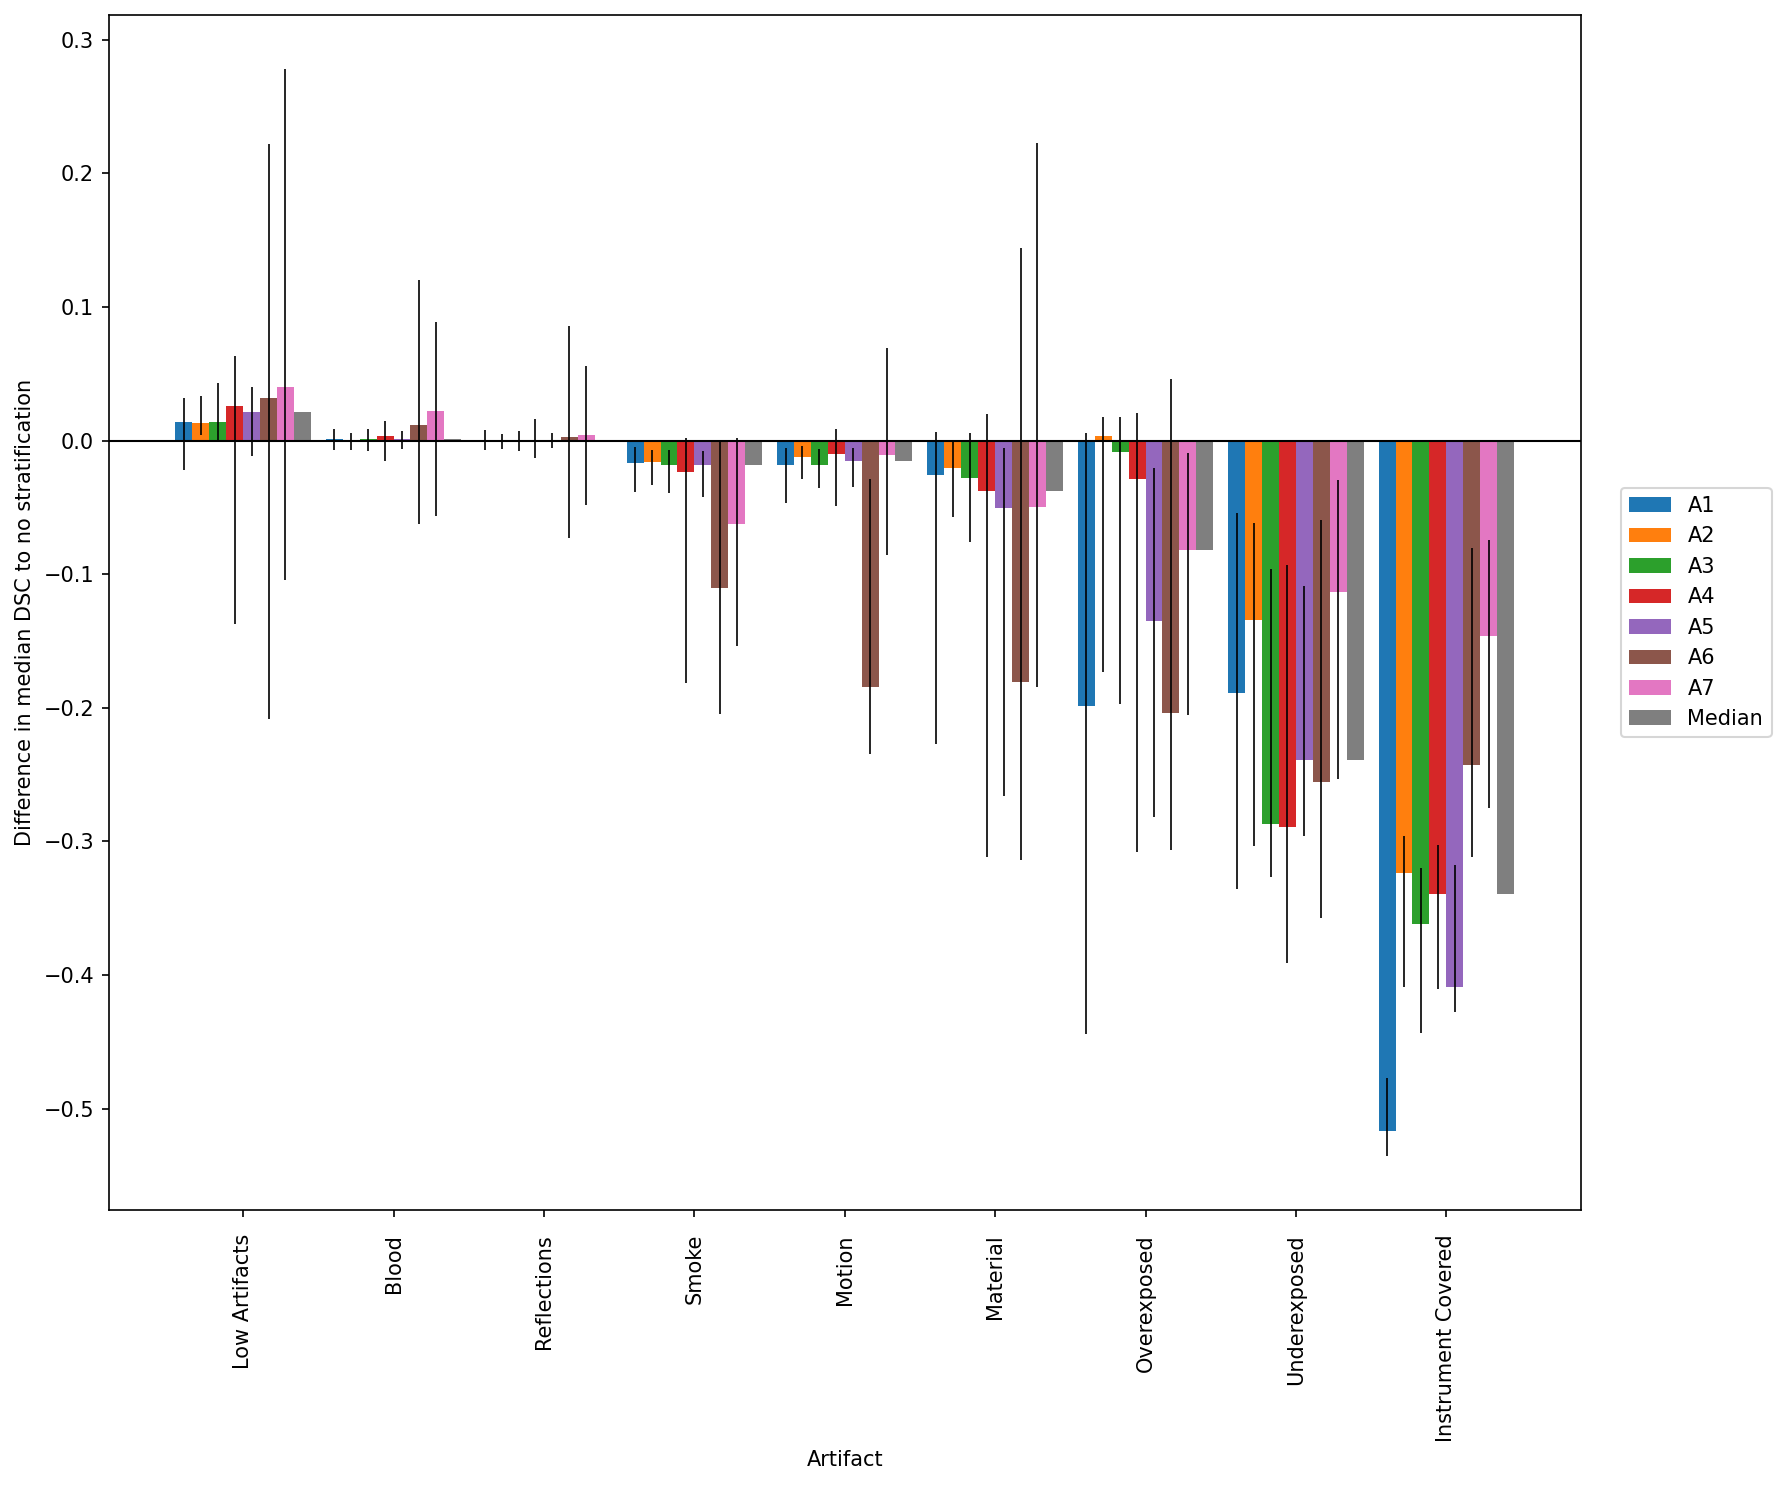

In [11]:
# Merge deltas with bootstrap confidence intervals
differences_with_ci = differences_restructured.merge(bootstrap_results, on=["Algorithm", "Artifact"], how="left")

# Prepare data for plotting
differences_with_ci_plot = (differences_with_ci.groupby(["Artifact", "Algorithm"], as_index=False).first())

desired = ["Low Artifacts","Blood","Reflections","Smoke","Motion","Material","Overexposed","Underexposed","Instrument Covered"]
artifacts = [a for a in desired if a in set(differences_with_ci_plot["Artifact"])]

algorithms = list(differences_with_ci_plot["Algorithm"].unique())

x = np.arange(len(artifacts))
n_alg = len(algorithms)
w = 0.9 / n_alg

fig, ax = plt.subplots(figsize=(12, 10), dpi=150)

for j, alg in enumerate(algorithms):
    sub = differences_with_ci_plot[differences_with_ci_plot["Algorithm"] == alg].set_index("Artifact")

    y  = np.array([sub.at[a, "value"]  if a in sub.index else np.nan for a in artifacts], float)
    lo = np.array([sub.at[a, "CI_Low"] if a in sub.index else np.nan for a in artifacts], float)
    hi = np.array([sub.at[a, "CI_High"]if a in sub.index else np.nan for a in artifacts], float)

    xpos = x + (j - (n_alg - 1)/2) * w
    ax.bar(xpos, y, width=w, label=alg)

    m = np.isfinite(lo) & np.isfinite(hi)
    ax.vlines(xpos[m], lo[m], hi[m], color="black", linewidth=0.8)

ax.set_xticks(x)
ax.set_xticklabels(artifacts, rotation=90, ha="center", va="top")
ax.tick_params(axis="x", pad=8)
ax.axhline(0, color="black", linewidth=1)
ax.set_ylabel("Difference in median DSC to no stratification")
ax.set_xlabel("Artifact")
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

In [12]:
differences_restructured[differences_restructured["Artifact"] == "Instrument Covered"]

,Algorithm,Artifact,value
1,Median,Instrument Covered,-0.339720
58,A1,Instrument Covered,-0.516791
59,A2,Instrument Covered,-0.323771
60,A3,Instrument Covered,-0.361741
61,A4,Instrument Covered,-0.339720
62,A5,Instrument Covered,-0.408725
63,A6,Instrument Covered,-0.242575
64,A7,Instrument Covered,-0.146445
